**IMPORTING LIBRARIES**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split

In [12]:
import xgboost as xgb
import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential

from sklearn.metrics import mean_squared_error,median_absolute_error,r2_score

import warnings
warnings.filterwarnings('ignore')

**LOADING DATA**

In [7]:
df=pd.read_csv('/content/SolarPrediction.csv')

In [14]:
df.shape

(32686, 11)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


In [15]:
df.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


In [8]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


**DATA WRAGLING**

In [16]:
df['Data']=df['Data'].apply(lambda x: x.split()[0])

In [17]:
df['Data']

0        9/29/2016
1        9/29/2016
2        9/29/2016
3        9/29/2016
4        9/29/2016
           ...    
32681    12/1/2016
32682    12/1/2016
32683    12/1/2016
32684    12/1/2016
32685    12/1/2016
Name: Data, Length: 32686, dtype: object

In [18]:
df['Month']=pd.to_datetime(df['Data']).dt.month

In [19]:
df['Day']=pd.to_datetime(df['Data']).dt.day
df['Hour']=pd.to_datetime(df['Time']).dt.hour

df['Minute']=pd.to_datetime(df['Time']).dt.minute
df['Second']=pd.to_datetime(df['Time']).dt.second



In [23]:
df.shape

(32686, 14)

In [22]:
df.drop(columns=['Data'],axis=1,inplace=True)

In [29]:
df['risehour']=pd.to_datetime(df['TimeSunRise']).dt.hour
df['sethour']=pd.to_datetime(df['TimeSunSet']).dt.hour

In [30]:
df['risemin']=pd.to_datetime(df['TimeSunRise']).dt.minute

In [32]:
df['setmin']=pd.to_datetime(df['TimeSunSet']).dt.minute

In [34]:
df.drop(columns=['TimeSunRise','TimeSunSet'],axis=1,inplace=True)

In [35]:
df.head()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,sethour,risemin,setmin
0,1475229326,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,18,13,13
1,1475229023,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,18,13,13
2,1475228726,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,18,13,13
3,1475228421,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,18,13,13
4,1475228124,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,18,13,13


In [36]:
df.drop(columns='UNIXTime',axis=1,inplace=True)

In [37]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,sethour,risemin,setmin
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,18,13,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,18,13,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,18,13,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,18,13,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,18,13,13


**Splitting into train and test features**

In [38]:
X=df.drop(columns='Radiation',axis=1)
Y=df['Radiation']

**Feature Selection**

In [39]:
cor=df.corr()

<Axes: >

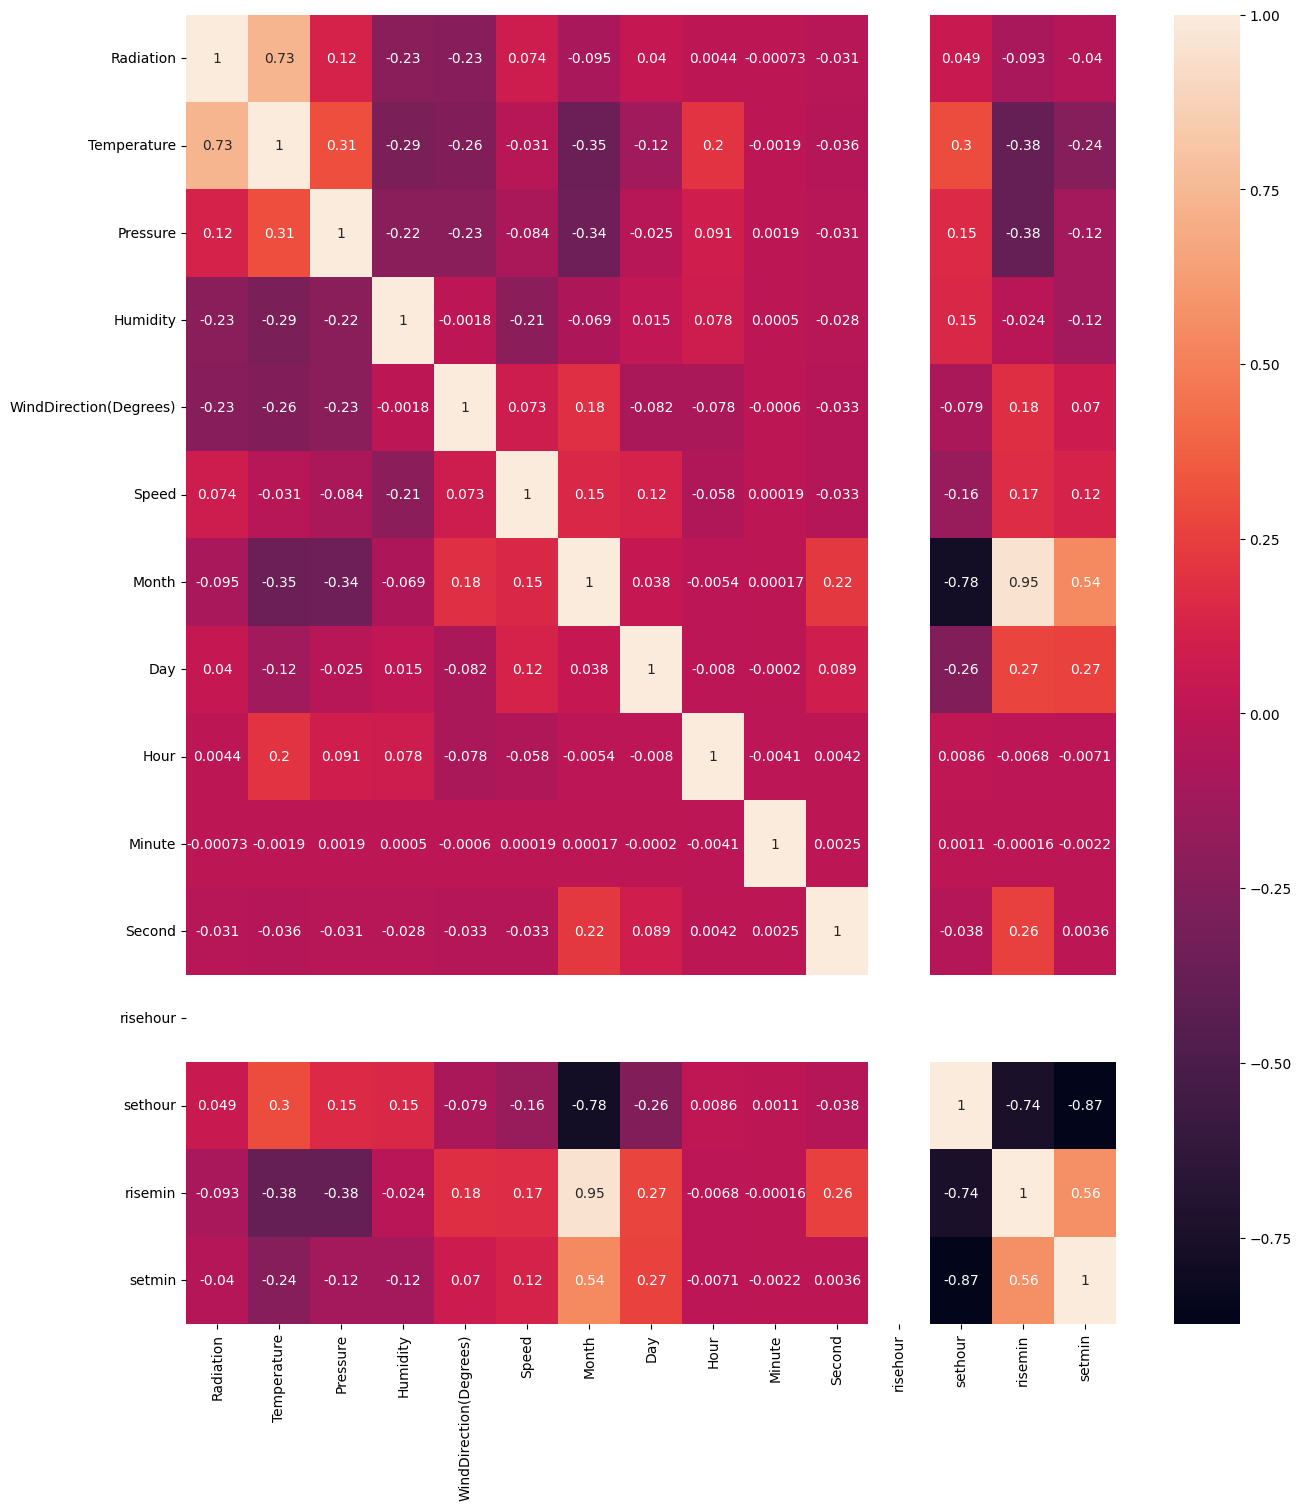

In [43]:
plt.figure(figsize=(15,17))
sns.heatmap(df.corr(),annot=True)

SelectKbest Method

In [46]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [47]:
best=SelectKBest(score_func=chi2,k=9)

In [48]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [49]:
Y_train=le.fit_transform(Y)

In [51]:
scaled = MinMaxScaler().fit_transform(X)

In [52]:
fit=best.fit(X,Y_train)

In [54]:
df1= pd.DataFrame(fit.scores_)
col = pd.DataFrame(df.columns)

In [56]:
features = pd.concat([col,df1],axis=1)

In [58]:
features.columns=['Features','ScoreValue']

In [59]:
features

,Features,ScoreValue
0,Radiation,2.050054e+04
1,Temperature,1.494613e+00
2,Pressure,1.357960e+05
3,Humidity,1.184645e+06
4,WindDirection(Degrees),3.125498e+04
5,Speed,2.053474e+03
6,Month,8.044041e+04
7,Day,1.616428e+04
8,Hour,1.555249e+05
9,Minute,1.364327e+05


ExtraTreeRegressor

In [65]:
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
model=ExtraTreesRegressor()
model.fit(X,Y)

ExtraTreesRegressor()

In [66]:
print(model.feature_importances_)

[0.38042761 0.01569223 0.05794593 0.06118766 0.0083897  0.00974722
 0.02433298 0.38004736 0.0141721  0.01028068 0.         0.01105695
 0.01401042 0.01270917]


<Axes: >

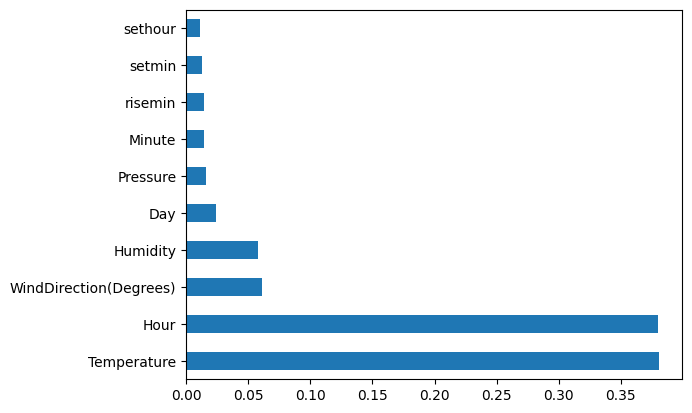

In [67]:
rank=pd.Series(model.feature_importances_,index=X.columns)
rank.nlargest(10).plot(kind='barh')

In [68]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)

In [69]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [70]:
X_train.shape

(22880, 14)

In [71]:
X_test.shape

(9806, 14)

**Model Building**

In [74]:
from xgboost import XGBRegressor

# Instantiate the model
model = XGBRegressor()

# Fit the model to the training data
model.fit(X_train, Y_train)

# Predict on the test data
y_pred = model.predict(X_test)

In [75]:
rsme = np.sqrt(mean_squared_error(Y_test,y_pred))
r2 = r2_score(Y_test,y_pred)

In [76]:
print(r2)

0.9167144447442249


In [77]:
print(rsme)

91.40417962509214
